In [22]:
# import data processing and visualisation libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import skimage
from skimage.transform import resize
from skimage import exposure

import tensorflow as tf
from tensorflow import keras
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Flatten
from tensorflow.keras import datasets, layers, models

import gc


In [23]:
batch_size = 64
imageSize = 64
target_dims = (imageSize, imageSize, 3)
num_classes = 26

def get_data(folder, max_images_per_class=3000):
    X = []
    y = []
    labels = {}
    label_index = 0
    for folderName in sorted(os.listdir(folder)):
        if not folderName.startswith('.'):
            labels[folderName] = label_index
            image_count = 0
            for image_filename in os.listdir(os.path.join(folder, folderName)):
                if image_count >= max_images_per_class:
                    break
                img_file = cv2.imread(os.path.join(folder, folderName, image_filename))
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    # img_file = img_file / 255.0
                    # img_file = exposure.equalize_hist(img_file)
                    X.append(img_file)
                    y.append(label_index)
                    image_count += 1
            label_index += 1
    return np.array(X), np.array(y)

train_dir = "./asl_dataset/"
X_train, y_train = get_data(train_dir, 3000)

print("Images successfully imported...")

print("Images successfully imported...")

Images successfully imported...
Images successfully imported...


In [24]:
print("the Shape of x train is : ", X_train.shape)
print("the Shape of y train is : ", y_train.shape)

the Shape of x train is :  (1815, 64, 64, 3)
the Shape of y train is :  (1815,)


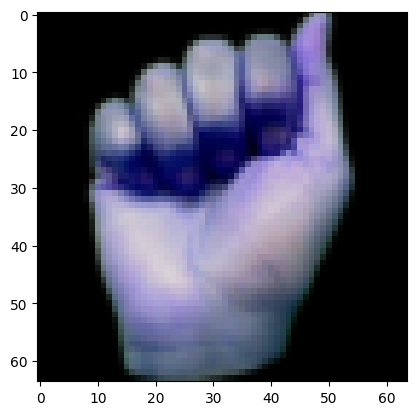

In [25]:
plt.imshow(X_train[0])
plt.show()

In [26]:
# Data Processingtotal
X_data = X_train
y_data = y_train

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3,random_state=42,stratify=y_data)

In [27]:
print(np.max(y_train))
print(num_classes)

25
26


In [28]:
# One-Hot-Encoding the categorical data

num_classes = np.max(y_train) + 1
y_cat_train = to_categorical(y_train, num_classes)
y_cat_test = to_categorical(y_test, num_classes)

In [29]:
# Checking the dimensions of all the variables
print(X_train.shape)
print(X_test.shape)
print(X_test.shape)
print(y_test.shape)
print(y_cat_train.shape)
print(y_cat_test.shape)

(1270, 64, 64, 3)
(545, 64, 64, 3)
(545, 64, 64, 3)
(545,)
(1270, 26)
(545, 26)


In [30]:
# CPU and RAM save

import gc
del X_data
del y_data
gc.collect()

7854

In [31]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))

model.summary()

/home/sachithrka/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,240,986 (4.73 MB)

 Trainable params: 1,240,986 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [33]:
history = model.fit(X_train, y_cat_train, 
          epochs=15,
          batch_size=64,
          verbose=2,
          validation_data=(X_test, y_cat_test))

Epoch 1/15
20/20 - 7s - 346ms/step - accuracy: 0.3969 - loss: 2.1059 - val_accuracy: 0.7505 - val_loss: 0.7498
Epoch 2/15
20/20 - 4s - 214ms/step - accuracy: 0.8630 - loss: 0.4141 - val_accuracy: 0.8862 - val_loss: 0.2709
Epoch 3/15
20/20 - 4s - 214ms/step - accuracy: 0.9378 - loss: 0.1910 - val_accuracy: 0.9450 - val_loss: 0.1615
Epoch 4/15
20/20 - 5s - 238ms/step - accuracy: 0.9795 - loss: 0.0733 - val_accuracy: 0.9780 - val_loss: 0.0715
Epoch 5/15
20/20 - 5s - 233ms/step - accuracy: 0.9858 - loss: 0.0487 - val_accuracy: 0.9541 - val_loss: 0.1210
Epoch 6/15
20/20 - 4s - 223ms/step - accuracy: 0.9898 - loss: 0.0331 - val_accuracy: 0.9780 - val_loss: 0.0825
Epoch 7/15
20/20 - 5s - 230ms/step - accuracy: 0.9976 - loss: 0.0126 - val_accuracy: 0.9706 - val_loss: 0.0963
Epoch 8/15
20/20 - 4s - 222ms/step - accuracy: 0.9984 - loss: 0.0079 - val_accuracy: 0.9853 - val_loss: 0.0548
Epoch 9/15
20/20 - 4s - 223ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9853 - val_loss: 0.0715
E

In [34]:
metrics = pd.DataFrame(model.history.history)
metrics

# 11 epochs are the limit for the maximum accuracy

,accuracy,loss,val_accuracy,val_loss
0,0.396850,2.105880,0.750459,0.749788
1,0.862992,0.414068,0.886239,0.270947
2,0.937795,0.190995,0.944954,0.161507
3,0.979528,0.073333,0.977982,0.071468
4,0.985827,0.048671,0.954128,0.120983
5,0.989764,0.033097,0.977982,0.082456
6,0.997638,0.012638,0.970642,0.096298
7,0.998425,0.007932,0.985321,0.054758
8,1.000000,0.002399,0.985321,0.071495
9,1.000000,0.000899,0.985321,0.053752


18/18 - 0s - 26ms/step - accuracy: 0.9853 - loss: 0.0564


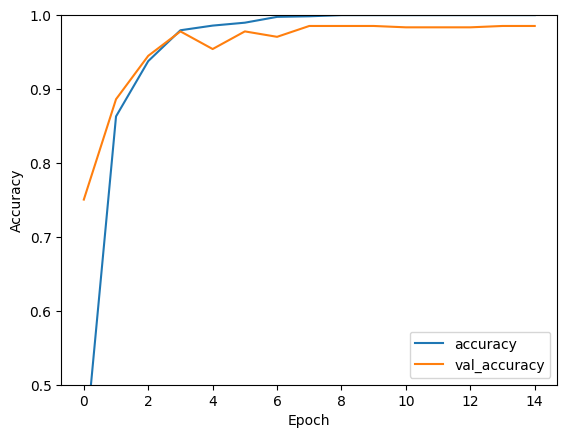

In [35]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_cat_test, verbose=2)

In [36]:
print(test_acc)

0.9853211045265198


In [72]:
train_dir_test = "./asl_alphabet_test/"
xx_train, yy_train = get_data(train_dir_test)

print("Images successfully imported...")

/home/sachithrka/.local/lib/python3.10/site-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


KeyboardInterrupt: 

In [17]:
from tensorflow.keras.models import load_model

predictions = model.predict(xx_train)

print("Predictions successfully made...")

204/204 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
Predictions successfully made...


In [18]:
from sklearn.metrics import classification_report
import numpy as np

predictions_class = np.argmax(predictions, axis=1)

print(classification_report(yy_train, predictions_class))

              precision    recall  f1-score   support

           0       0.02      0.04      0.03       250
           1       0.00      0.00      0.00       250
           2       0.00      0.00      0.00       250
           3       0.00      0.00      0.00       250
           4       0.00      0.00      0.00       250
           5       0.00      0.00      0.00       250
           6       0.11      0.04      0.06       250
           7       0.27      0.03      0.05       250
           8       0.00      0.00      0.00       250
           9       0.03      0.27      0.05       250
          10       0.00      0.00      0.00       250
          11       0.00      0.00      0.00       250
          12       0.03      0.08      0.04       250
          13       0.03      0.05      0.04       250
          14       0.00      0.00      0.00       250
          15       0.07      0.00      0.01       250
          16       0.14      0.03      0.05       250
          17       0.00    

/home/sachithrka/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sachithrka/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sachithrka/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
# Save the model
model.save('asl_full_model.h5')
